# Ucitavanje biblioteka

In [1]:
# ucitavanje biblioteka potrebnih za rad
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import random
 
random.seed()

## Model (wt i vt su beli Gausovsko šumovi sa varijansama 2 i 1, respektivno)

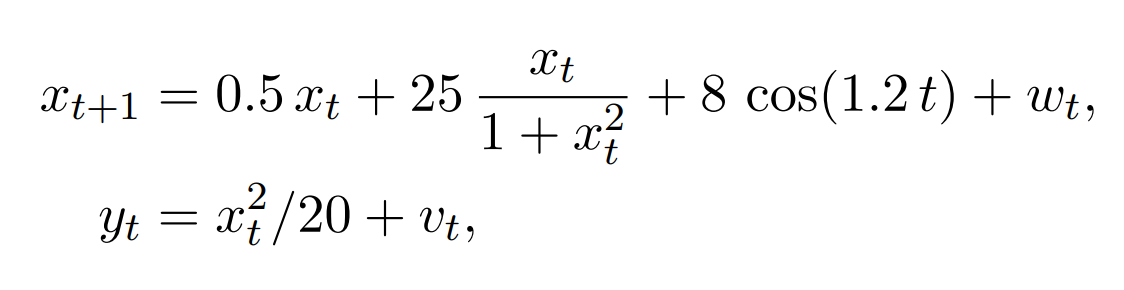

## Implementacija čestičnog filtra

In [12]:
# standardna devijacija suma model
sigma_w = 2**0.5

# standardna devijacija suma merenja
sigma_v = 1

# maksimalno vreme
Time_max = 50

# funkcija za inicijalizaciju procesa
def initialize(N):
    
    x0 = np.random.uniform(-1, 1,N)
        
    weights = (1/N)*np.ones((N,))
    
    return x0, weights

# funkcija modela
def model(x_curr, t_val):
    
    N = x_curr.size
    
    x_next = 0.5*x_curr + 25*x_curr/(1+x_curr**2) + 8*np.cos(1.2*t_val) + np.random.normal(scale=sigma_w, size=N)
    
    return x_next
    
# funkcija za dohvatanje predikcija na osnovu modela
def get_predictions(xt, t_val):

    global sigma_w
    
    predictions = np.zeros_like(xt)
    
    predictions = model(xt, t_val)
    
    return predictions

# funkcija za azuriranje tezina cestica na osnovu prethodnih
# tezina, predikcija i trenutne observacije
def update_weights(weights, predictions, observation):
    
    global sigma_v
    
    new_weights = np.zeros_like(weights)
    
    new_weights = weights*np.exp(-(observation-np.power(predictions,2)/20)**2/(2*sigma_v**2))
    
    w_sum = np.sum(new_weights)
    
    new_weights /= w_sum
    
    return new_weights

# funkcija za dohvatanje observacije/merenja
def get_observation(xt):
    
    global sigma_v
    
    yt = xt**2/20 + np.random.normal(scale=sigma_v)
    
    return yt

# funkcija za proracunavanje trenutne estimacije stanja
def get_estimation(predictions, weights):
    
    estimation = np.sum(predictions*weights)
    
    return estimation

# funkcija za reuzorkovanje
def resampling(xt, weights):
    
    N = xt.size
    
    new_xt = np.array(random.choices(xt, weights, k = N))
    
    new_weights = (1/N)*np.ones((N,))
    
    return new_xt, new_weights

# funkcija za generisanje trajektorije
def generate_trajectory():
    
    global Time_max
    
    x0, _ = initialize(1)
    
    # +1 za x0 i Time_max + 1 za sve vreme
    x = np.zeros((Time_max+2,))
    
    x[0] = x0[0]

    for i in range(0,Time_max+1):
        t = i
        x[i+1] = model(x[i], t)
    
    return x[1:]

# funkcija za simulaciju cesticnog filtra 
# na osnovu prosledjene trajektorije, broj cestica
# i da li dolazi do reuzorkovanja ili ne
def particle_filter(x_traj, N, resample = False):
    
    global Time_max
    
    X = np.zeros((N,Time_max+2))
    Y = np.zeros((Time_max+2,))
    X_est = np.zeros((Time_max+1,))
    
    W = np.zeros((N,Time_max+2))
    
    x_curr, weights = initialize(N)
    
    x_curr = np.array(x_curr)
    
    X[:,0] = x_curr
    W[:,0] = weights
    
    for t in range(0,Time_max + 1):
        
        x_predict = get_predictions(x_curr, t)
        
        X[:,t+1] = x_predict
        
        y_obs = get_observation(x_traj[t])
        
        Y[t+1] = y_obs
        
        weights = update_weights(weights, x_predict, y_obs)
        
        W[:,t+1] = weights
        
        x_est = get_estimation(x_predict, weights)
        
        X_est[t] = x_est
        
        if resample and t != Time_max:
            x_curr, weights = resampling(x_predict, weights)
        
        else: 
            x_curr = x_predict
            
    sigma_t = np.sqrt(np.sum(W[:,1:]*(X[:,1:] - X_est)**2, axis=0))
    
    metric_1 = np.sum(np.abs(x_traj-X_est) > 2*sigma_t)/(Time_max+1)*100 
    metric_2 = np.sqrt(np.mean((x_traj-X_est)**2))
    
    metrics = [metric_1, metric_2]
    
    two_sigma_intervals = np.zeros((2,Time_max+1))
    
    two_sigma_intervals[0,:] = X_est + 2*sigma_t
    two_sigma_intervals[1,:] = X_est - 2*sigma_t
            
    return X, X_est, W, Y, two_sigma_intervals, metrics

## Izbor broja čestica na osnovu metrika

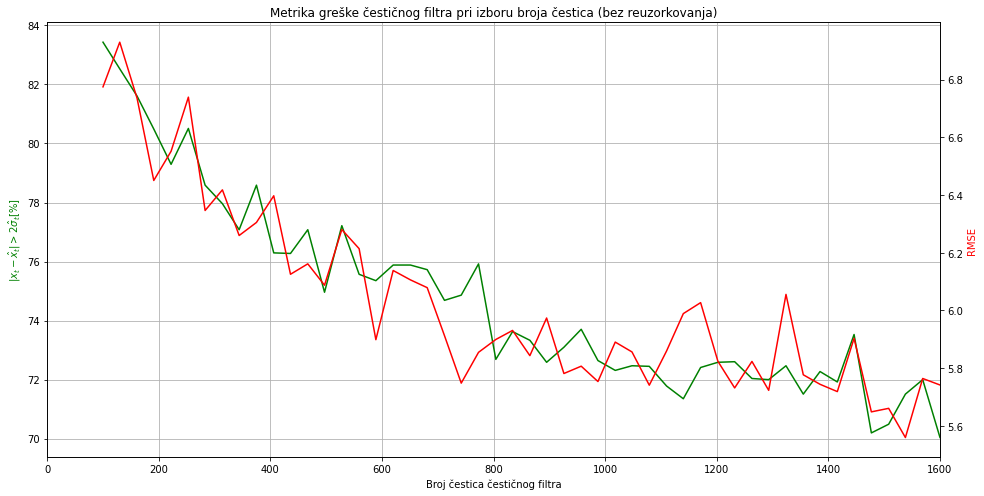

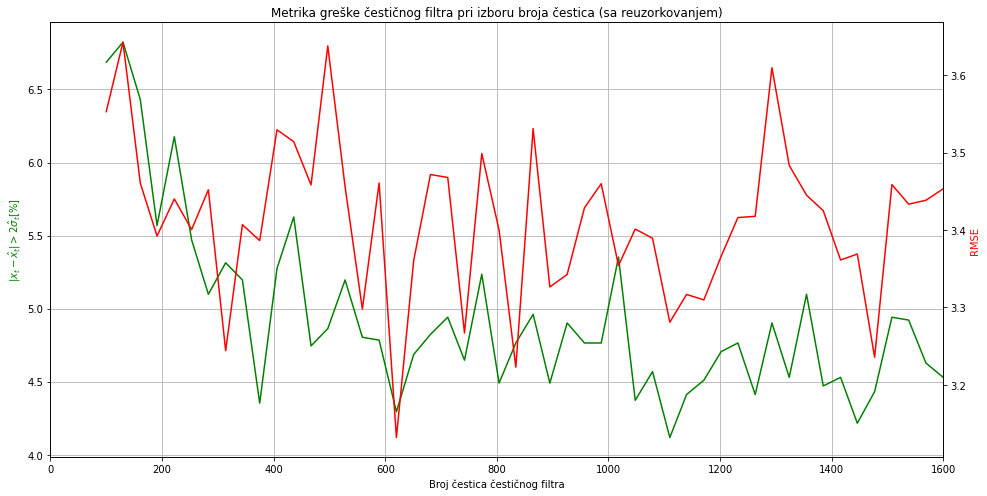

In [13]:
# broj eksperimenata za odredjivanje optimalnog broja cestica
Nr = 100

# broj mogucih cesticq
N_particles = np.linspace(100, 1600, 50, dtype=int)

# petlja za reuzorkovanje, odnosno bez reuzrokovanja
for r in [False, True]:
    
    # matrica rezultata metrika
    metrics = np.zeros((N_particles.size, 2))

    for (i, N) in zip(range(N_particles.size), N_particles):
        
        for j in range(Nr):
            
            # generisanje trajektorije
            xt = generate_trajectory()
            
            # upotreba cesticnog filtra za procenu odgovarajuceg broja cestica
            metrics[i,:] += np.array(particle_filter(xt,N, r)[-1])
    
    # usrednjavanje po svakih Nr realizacija
    metrics /= Nr

    # plotovanje rezultata metrika
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    color1 = 'green'
    color2 = 'red'

    ax2 = ax1.twinx()
    ax1.plot(N_particles, metrics[:,0], color=color1)
    ax2.plot(N_particles, metrics[:,1], color=color2)

    ax1.set_xlabel('Broj čestica čestičnog filtra')
    
    # metrika 1
    ax1.set_ylabel('$|x_{t}-\hat{x}_{t}| > 2\hat{\sigma}_{t} [\%]$', color=color1)
    # metrika 2 
    ax2.set_ylabel('RMSE', color=color2)
    ax1.set_title('Metrika greške čestičnog filtra pri izboru broja čestica (%s)' %('sa reuzorkovanjem' if r else 'bez reuzorkovanja'))
    ax1.set_xlim([0, np.max(N_particles)])
    
    ax1.grid(which='major')
    plt.show()

## Simulacija algoritma

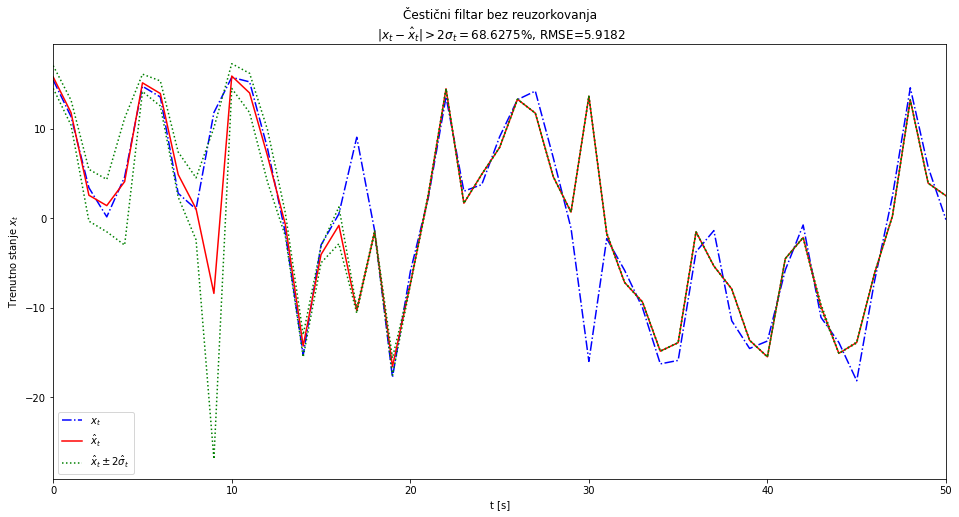

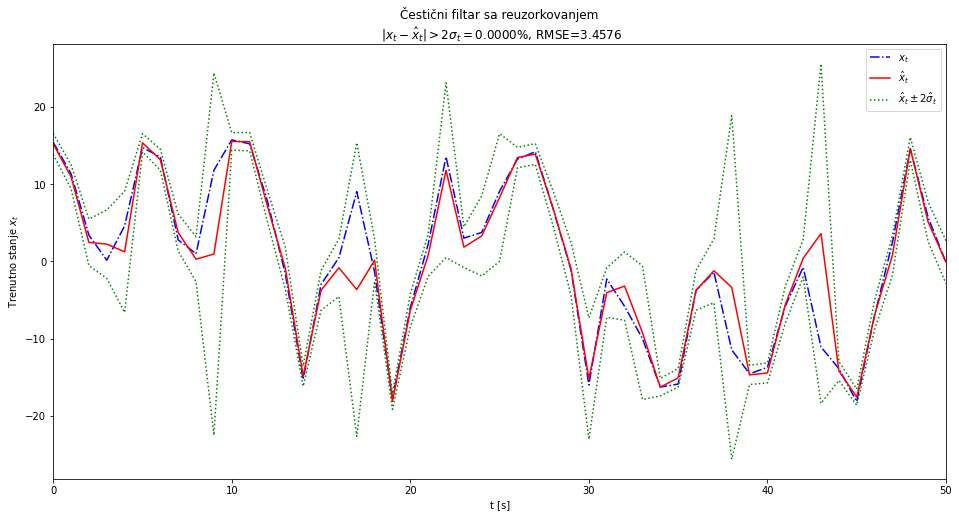

In [14]:
# generisanje trajektorije
xt = generate_trajectory()

# optimalan broj čestica
N = 1000

# vremenska osa
t = np.arange(Time_max + 1)

for r in [False, True]:
    
    X, X_est, W, Y, two_sigma_intervals, metrics = particle_filter(xt, N, r)
    
    fig, ax = plt.subplots(figsize=(16,8))
    
    # plotovanje trajektorije
    trajectory, = ax.plot(t, xt, color='blue', ls='-.', label = '$x_{t}$')
    
    # plotovanje estimacija
    estimation, = ax.plot(t, X_est, color='red', label = '$\hat{x}_{t}$')
    
    intervals, = ax.plot(t, two_sigma_intervals[0,:], color='green', ls='dotted', label = '$\hat{x}_{t} \pm 2\hat{\sigma}_{t}$')
    ax.plot(t, two_sigma_intervals[1,:], color='green', ls='dotted')
    
    ax.set_xlabel('t [s]')
    ax.set_ylabel('Trenutno stanje $x_{t}$')
    ax.set_xlim([0, Time_max])
    
    ax.set_title('Čestični filtar %s\n $|x_{t}-\hat{x}_{t}| > 2\sigma_{t}=$%.4f%%, RMSE=%.4f'
                 %('sa reuzorkovanjem' if r else 'bez reuzorkovanja', metrics[0], metrics[1]))
    plt.legend(handles = [trajectory, estimation, intervals])
    plt.show()